# ADZD Lab1 - RDD
**Author: Bartłomiej Jamiołkowski**

Using RDD operations and an Apache2 log file:

## Libraries

In [1]:
from pyspark.sql import SparkSession
from collections import defaultdict, Counter, OrderedDict
from datetime import datetime
import urllib.request
import ipinfo
import cartopy.crs as ccrs
import re
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Spark initialization

In [2]:
spark = SparkSession.builder.getOrCreate()
spark

In [3]:
sc = spark.sparkContext

## Data retrieval

In [4]:
urllib.request.urlretrieve('http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs','apache_logs')

('apache_logs', <http.client.HTTPMessage at 0x7f164961ec90>)

In [5]:
data = sc.textFile('apache_logs')
data.collect()[:4]

['83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:47 +0000] "GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1" 200 26185 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.

## Exercise 1
Plot a ranking chart of the most popular source pages (referrer), excluding the **semicomplete.com** domain.

In [6]:
domain_regex = r'https?://(:?www\.|)(.*?)(/|\")|\"-\"'
excluded_domain = 'semicomplete.com'

def extract_domain(s):
    match = re.search(domain_regex, s)
    if match:
        return match.group(2)
    return None

domain_counts = (data
    .filter(lambda s: excluded_domain not in s)    
    .map(lambda s: (extract_domain(s), 1))
    .filter(lambda x: x[0] is not None)
    .reduceByKey(operator.add)
    .takeOrdered(15, lambda x: -x[1])
)

domain_counts

[('google.com', 144),
 ('s-chassis.co.nz', 51),
 ('stackoverflow.com', 34),
 ('logstash.net', 31),
 ('google.co.uk', 24),
 ('google.fr', 15),
 ('google.co.in', 13),
 ('google.de', 13),
 ('tuxradar.com', 12),
 ('en.wikipedia.org', 10),
 ('kufli.blogspot.com', 10),
 ('google.com.br', 9),
 ('google.com.hk', 9),
 ('unix.stackexchange.com', 8),
 ('google.se', 7)]

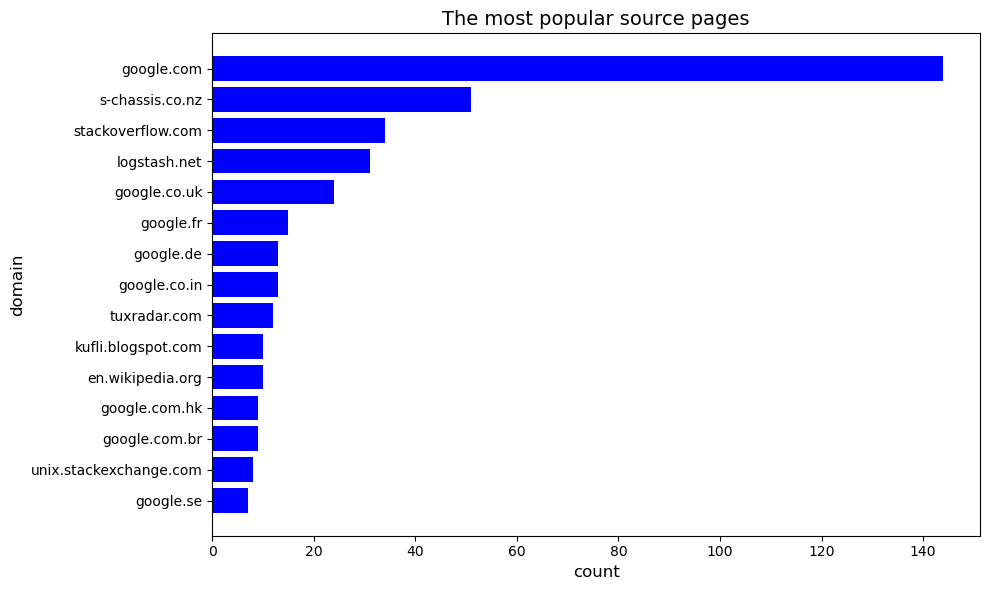

In [8]:
domain_df = pd.DataFrame(domain_counts, columns=['domain', 'count'])
domain_df = domain_df.sort_values(by='count', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(domain_df['domain'], domain_df['count'], color='blue')
plt.title('The most popular source pages', fontsize=14)
plt.xlabel('count', fontsize=12)
plt.ylabel('domain', fontsize=12)
plt.tight_layout()
plt.show()

## Exercise 2
Plot a ranking chart of downloaded graphic files.

In [9]:
extension_regex = '\"GET \S+\.([a-zA-Z]+) '

def extract_extension(s):
    match = re.search(extension_regex, s)
    if match:
        return match.group(1)
    return None

extension_counts = (data
    .filter(lambda s: 'GET' in s)
    .map(lambda s: (extract_extension(s), 1))
    .filter(lambda s: None not in s)
    .reduceByKey(operator.add)
    .filter(lambda x: x[1] > 0)
    .takeOrdered(10, lambda x: -x[1])
)

extension_counts[:10]

[('png', 2331),
 ('css', 1458),
 ('ico', 800),
 ('html', 753),
 ('jpg', 257),
 ('js', 250),
 ('txt', 192),
 ('gif', 184),
 ('xhtml', 153),
 ('jar', 90)]

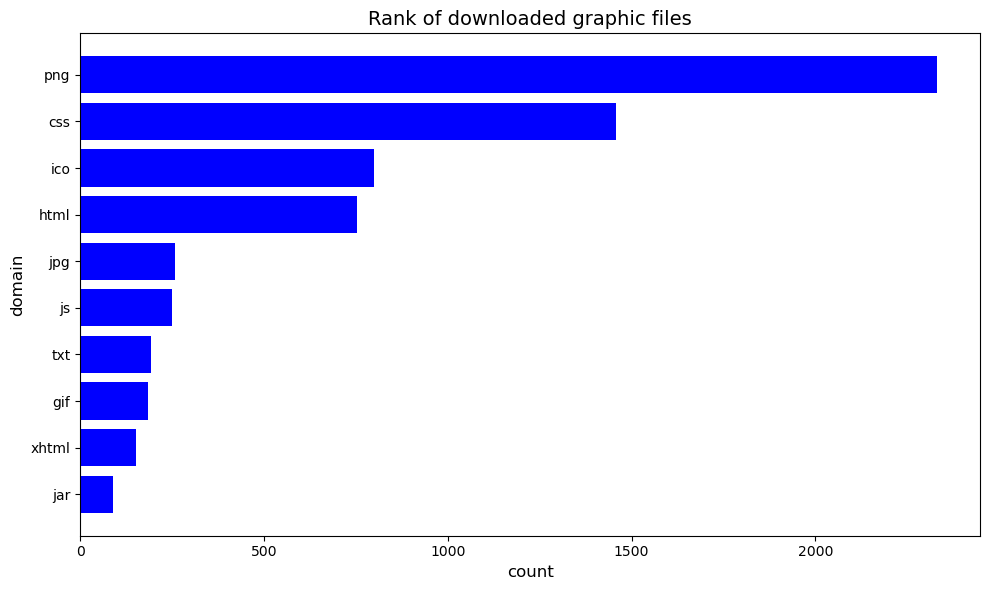

In [10]:
extension_df = pd.DataFrame(extension_counts, columns=['extension', 'count'])
extension_df = extension_df.sort_values(by='count', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(extension_df['extension'], extension_df['count'], color='blue')
plt.title('Rank of downloaded graphic files', fontsize=14)
plt.xlabel('count', fontsize=12)
plt.ylabel('domain', fontsize=12)
plt.tight_layout()
plt.show()

## Exercise 3
Plot an average daily chart of the number of requests per minute over time.

In [11]:
datetime_regex = re.compile(r'\[(\d{2}/[A-Za-z]{3}/\d{4}:\d{2}:\d{2})')

def extract_datetime(s):
    match = re.search(datetime_regex, s)
    if match:
        return match.group(1)
    return None

requests_per_minute_counts = (
    data
    .map(lambda s: extract_datetime(s))
    .filter(lambda s: s is not None)
    .map(lambda s: (s, 1))
    .reduceByKey(lambda a, b: a + b)
)

requests_per_minute_counts.collect()[:10]

[('17/May/2015:11:05', 111),
 ('17/May/2015:12:05', 115),
 ('17/May/2015:13:05', 118),
 ('17/May/2015:16:05', 126),
 ('17/May/2015:19:05', 121),
 ('17/May/2015:22:05', 118),
 ('17/May/2015:23:05', 111),
 ('18/May/2015:01:05', 118),
 ('18/May/2015:02:05', 125),
 ('18/May/2015:03:05', 114)]

In [13]:
requests_per_minute_dict = defaultdict(list)

for datetime, daily_count in requests_per_minute_counts.collect():
    hour_minute = datetime[12:17]  # Extracting HH:MM
    requests_per_minute_dict[hour_minute].append(daily_count)

avg_requests_per_minute = {time: round(np.mean(daily_counts), 2) for time, daily_counts in requests_per_minute_dict.items()}
avg_requests_per_minute = OrderedDict(sorted(avg_requests_per_minute.items()))

df_avg_requests_per_minute = pd.DataFrame.from_dict(avg_requests_per_minute, orient='index', columns=['avg_requests_per_minute'])
df_avg_requests_per_minute.index = pd.to_datetime(df_avg_requests_per_minute.index, format='%H:%M').strftime('%H:%M')
df_avg_requests_per_minute

,avg_requests_per_minute
00:05,120.33
01:05,120.00
02:05,121.67
03:05,118.00
04:05,118.33
05:05,123.67
06:05,122.00
07:05,119.00
08:05,115.00
09:05,121.33


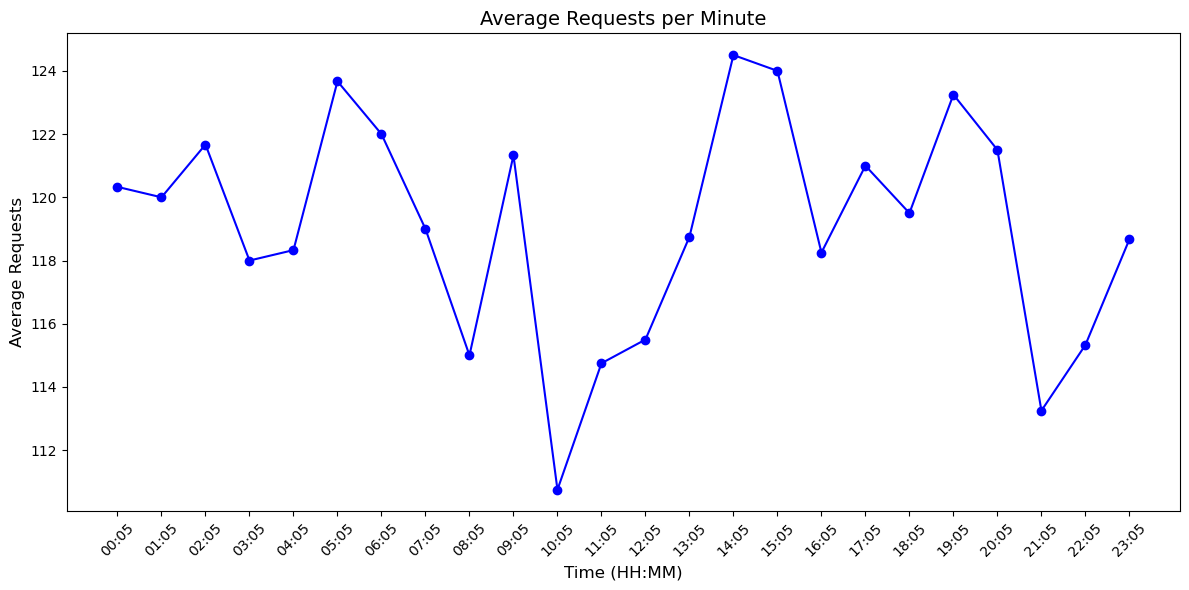

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df_avg_requests_per_minute.index, df_avg_requests_per_minute['avg_requests_per_minute'], marker='o', linestyle='-', color='blue')
plt.title('Average Requests per Minute', fontsize=14)
plt.xlabel('Time (HH:MM)', fontsize=12)
plt.ylabel('Average Requests', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Exercise 4
Plot a pie chart of the popularity of client operating systems

In [15]:
os_regex = r'(?i)(Windows|Mac\s?OS|Macintosh|Android|Linux|Ubuntu|Debian|Fedora|CentOS|Red\s?Hat|Gentoo|Arch\s?Linux|iPhone\s?OS|iPad|iOS|Chrome\s?OS|BlackBerry|Symbian|webOS|PlayStation|Xbox|SunOS| \
            FreeBSD|OpenBSD|NetBSD|Solaris|Haiku|BeOS|AmigaOS|MorphOS|Tizen|MeeGo|Sailfish|Raspberry\s?Pi\s?OS|OpenWrt)'

os_normalization = {
    'windows': 'Windows',
    'macintosh': 'Mac OS',
    'ios': 'iOS',
    'ubuntu': 'Ubuntu',
    'linux': 'Linux',
    'android': 'Android',
    'fedora': 'Fedora',
    'centos': 'CentOS',
    'freebsd': 'FreeBSD',
    'blackberry': 'BlackBerry',
    'netbsd': 'NetBSD',
    'openbsd': 'OpenBSD',
    'sunos': 'SunOS',
    'xbox': 'Xbox',
    'playstation': 'PlayStation',
    'haiku': 'Haiku',
    'beos': 'BeOS',
    'tizen': 'Tizen',
    'meego': 'MeeGo',
    'raspberry pi os': 'Raspberry Pi OS',
    'ipad': 'iPad',
    'solaris': 'Solaris',
    'iphone os': 'iPhone OS'
}

def extract_os(s):
    match = re.search(os_regex, s)
    if match:
        return match.group(0).lower()
    return None

os_counts = (data
    .map(lambda os: extract_os(os))
    .filter(lambda os: os is not None)
    .map(lambda os: (os_normalization.get(os, os), 1))
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

os_counts

[('iOS', 208),
 ('Linux', 1790),
 ('Fedora', 3),
 ('Android', 58),
 ('SunOS', 1),
 ('CentOS', 1),
 ('BlackBerry', 1),
 ('NetBSD', 2),
 ('Mac OS', 1321),
 ('Ubuntu', 588),
 ('iPhone OS', 345),
 ('Windows', 3177),
 ('Xbox', 20),
 ('Solaris', 18),
 ('iPad', 60),
 ('OpenBSD', 1)]

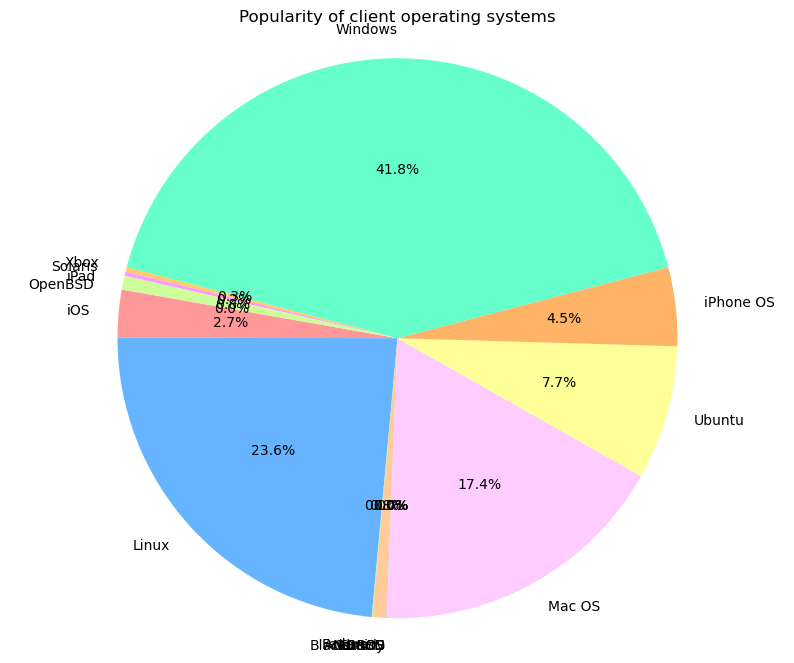

In [16]:
os_df = pd.DataFrame(os_counts, columns=['os', 'count'])

colors = [
    '#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666', '#c2f0c2', '#ffccff', '#ffff99', '#ffb366', '#66ffcc', '#ffcc66', '#ff99ff', '#ccff99', '#ffb3cc', '#cce6ff'
]

plt.figure(figsize=(10, 8))
plt.pie(x = os_df['count'], labels=os_df['os'], autopct='%1.1f%%', startangle=170, colors = colors)
plt.axis('equal')
plt.title('Popularity of client operating systems')
plt.show()

## Exercise 5
Estimate the percentage of traffic generated by bots. Compare at least 2 methods of estimation.

**Method 1**

In [17]:
bots_set = {'Googlebot', 'AskJeeves', 'Digger', 'Lycos', 'msnbot', 'Inktomi Slurp', 'Yahoo', 'Nutch', 'bingbot', 'BingPreview', 'Mediapartners-Google', 'proximic', 'AhrefsBot', 
            'AdsBot-Google', 'Ezooms', 'AddThis.com', 'facebookexternalhit', 'MetaURI', 'Feedfetcher-Google', 'PaperLiBot', 'TweetmemeBot', 'Sogou web spider', 'GoogleProducer',
            'RockmeltEmbedder', 'ShareThisFetcher', 'YandexBot', 'rogerbot-crawler', 'ShowyouBot', 'Baiduspider', 'Sosospider', 'Exabot', 'MJ12bot', 'SeznamBot', 'Bingbot', 
            'DuckDuckBot', 'LinkedInBot', 'Archive.org', 'WebCrawler', 'Screaming Frog SEO Spider', 'LinkCrawler', 'NetcraftSurveyAgent', 'bot.semrush.com', 'DotBot', 'Grapeshot', 
            'DomainTools', 'Coccoc', 'MetaRank', 'SitemapGenerator', 'MegaIndex', 'CrawlBot', 'Crawly', 'OpenLinkProfiler', 'VeraBot', 'CripBot', 'CydralBot', 'Pinterestbot', 
            'OnPage.org', 'Trendiction', 'Yeti', 'Bubla', 'WebZinger', 'guybot', 'JikeBot'}

bot_count_1 = (data
    .filter(lambda s: any(bot in s for bot in bots_set))
    .count()
)

bot_perc_1 = round(100 * (bot_count_1 / data.count()), 2)
print(f'Percentage of traffic generated by bots: {bot_perc_1} %')

Percentage of traffic generated by bots: 13.86 %


**Method 2**

In [18]:
error_regex = r'\b(404|403|500)\b'

def extract_errors(s):
    match = re.search(error_regex, s)
    if match:
        return match.group(0)
    return None

bot_count_2 = (data
    .map(lambda s: extract_errors(s))
    .filter(lambda s: s is not None)
    .count()
)

bot_perc_2 = round(100 * (bot_count_2 / data.count()), 2)
print(f'Percentage of traffic generated by bots: {bot_perc_2} %')

Percentage of traffic generated by bots: 2.18 %


Answer: Obtained results indicate that method 1 is more effective in detecting traffic generated by bots.

## Exercise 6
Plot a map with client locations.

In [19]:
ip_regex = '[(\d\.)]+'

def extract_ip(s):
    match = re.match(ip_regex, s)
    if match:
        return match.group(0)
    return None

ips = (data
    .map(lambda s: extract_ip(s))
    .distinct()
    .collect()
)

ips[:10]

['83.149.9.216',
 '24.236.252.67',
 '93.114.45.13',
 '66.249.73.135',
 '50.16.19.13',
 '66.249.73.185',
 '50.150.204.184',
 '207.241.237.225',
 '200.49.190.101',
 '200.49.190.100']

In [20]:
handler = ipinfo.getHandler(access_token='79a2b3b0e1489b')
response = handler.getBatchDetails(ips)
locations = [
    (float(lattitude), float(longtitude)) for details in response.values()
    if (location := details.get('loc')) is not None
    for lattitude, longtitude in [location.split(',')]
]

locations[:10]

[(55.7522, 37.6156),
 (42.7875, -86.1089),
 (44.4323, 26.1063),
 (36.154, -95.9928),
 (36.154, -95.9928),
 (39.0437, -77.4875),
 (37.3394, -121.895),
 (14.6407, -90.5133),
 (14.6407, -90.5133),
 (37.3394, -121.895)]

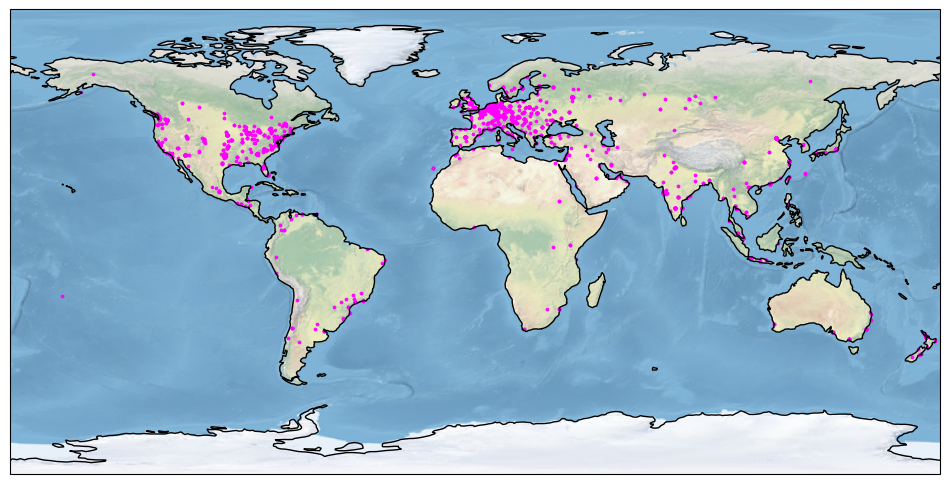

In [21]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
lattitudess, longtitudes = zip(*locations)

plt.scatter(x=longtitudes, y=lattitudess, color='magenta', s=3, alpha=0.9, transform=ccrs.PlateCarree()
)

plt.show()